# Quality Control in Manufacturing - Automatic Defect Detection
<h3><span style="color: #117d30;"> Using Azure Custom Vision Congnitive Services</span></h3>

## Scenario Overview

**Azure Custom Vision** is a cognitive service which helps in building and deploying object detection and image classification models. 

This notebook provides an end-to-end demo on how to use the Azure Cognitive Services Custom Vision API to build and deploy a classification model for **automated sub-assembly inspection for quality control purpose**. 

In this scenario we will see how the model will classify whether a given item is good or defective. If the model classifies the given piece as defective, it will be automatically marked as defective.

### Setting-Up: 

+ Defining the storage, file path and file name for **raw input** images
+ Defining the storage, file path and file name for **processed output** images
+ Downloading the images from an **ADLS Gen2 storage container**

In [1]:
# importing libraries for ADLS Gen2 connection
import os
from azure.storage.blob import BlockBlobService

# Importing user defined config
import config

# setting up blob storage configs
STORAGE_ACCOUNT_NAME = config.STORAGE_ACCOUNT_NAME
STORAGE_ACCOUNT_ACCESS_KEY = config.STORAGE_ACCOUNT_ACCESS_KEY
STORAGE_CONTAINER_NAME = "qualitycontrol"

# creating blob service object and list blobs inside input_folder
input_folder="input/"
output_folder="output/"
blob_service = BlockBlobService(STORAGE_ACCOUNT_NAME, STORAGE_ACCOUNT_ACCESS_KEY)
generator= blob_service.list_blobs(STORAGE_CONTAINER_NAME, prefix=input_folder)

# initializing several lists that will be used in the following cells
input_list=[]
output_list=[]
blob_file_list=[]
blob_output_list=[]

# creating the input and output folders if they do not exist
if not os.path.isdir("input"):
   os.mkdir("input")
if not os.path.isdir("output"):
   os.mkdir("output")

# getting the names of blob files and appending them to the list
for c in generator:
    blob_file_list.append(c.name)

# downloading the images from ADLS Gen2 storage
for i,blob_file in enumerate(blob_file_list):
     local_path = os.path.join(os.getcwd(), blob_file)
     blob_service.get_blob_to_path(STORAGE_CONTAINER_NAME, blob_file ,local_path)

# creating several lists
for i,image in enumerate(os.listdir("input")):
    full_path=os.path.join(os.getcwd(),"input",image)
    output_path=os.path.join(os.getcwd(),"output",image)
    blob_output="output/" + image
    input_list.append(full_path)
    output_list.append(output_path)
    blob_output_list.append(blob_output)

## Installing OpenCV and importing other python libraries  

OpenCV is one of the most popular computer vision libraries for image and video processing. In this notebook, we will install python binding for  OpenCV. 

We will also import other libraries like  **matplotlib**,  **numpy**, **pandas**, etc. that are required at different stages in this notebook for manipulating and processing images.    

In [2]:
# installing OpenCv and grequests libraries and importing the OpenCV library 
# openCV will be used to convert the frames into arrays   

!pip install opencv-python-headless
!pip install grequests

import cv2 

# for processing arrays   
import numpy as np

# for encoding and decoding Custom Vision predictions 
import json

# for converting the Custom Vision predictions to dataframe   
import pandas as pd

# for making web service calls in batches
import grequests 

# for displaying images from the processed images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# importing other required libraries
import io
import time
from PIL import ImageFont, ImageDraw, Image

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/grequests.py:22: MonkeyPatchWarning: Monkey-patching ssl after ssl has already been imported may lead to errors, including RecursionError on Python 3.6. It may also silently lead to incorrect behaviour on Python 3.7. Please monkey-patch earlier. See https://github.com/gevent/gevent/issues/1016. Modules that had direct imports (NOT patched): ['urllib3.contrib.pyopenssl (/anaconda/envs/azureml_py36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py)', 'urllib3.util (/anaconda/envs/azureml_py36/lib/python3.6/site-packages/urllib3/util/__init__.py)']. 
  curious_george.patch_all(thread=False, select=False)


### Displaying raw images before processing


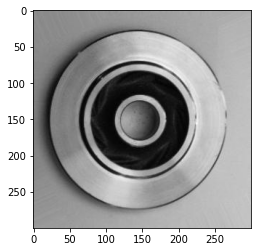

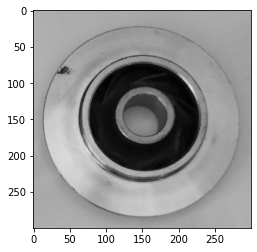

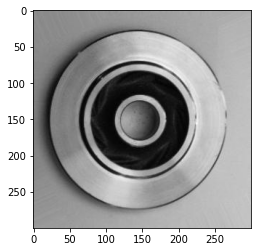

In [3]:
#displaying the raw images before processing
for _,file in enumerate(input_list):
   img = mpimg.imread(file)
   imgplot = plt.imshow(img)
   plt.show()

## Making API Call to Custom Vision Cognitive Service  

Now we will define connections details for making the API call to the Custom Vision Service 


In [4]:
# web service end-point foe the Custom Vision model    
# we will process images  
POST_URL = config.QUALITY_CONTROL_POST_URL
print(POST_URL)
# providing prediction key
HEADERS = config.QUALITY_CONTROL_HEADERS
print(HEADERS)

# number of API calls per pool of request   
MAX_CONNECTIONS = 100

## Functions to Converting Raw Input Images to Processed Images


### function: getFrames

This function takes a  list of image files as input and returns list of frames    


In [5]:
# returns list of arrays from list of images
def getFrames(input_list):
    images = []
    byteImages = []
    for _,k in enumerate(input_list):
        image = cv2.imread(k)
        images.append(image)
        global HEIGHT, WIDTH
        HEIGHT, WIDTH, lay = images[0].shape
    return images

### function: convertCVImagesToByteImages

This function takes a list of frames as input and returns list of Byte arrays 

In [6]:
# returns list of byte arrays
def convertCVImagesToByteImages(frames):
    toReturnByteImages = []
    for frame in frames:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        is_success, im_buf_arr = cv2.imencode(".jpg", image)
        if is_success:
            byte_im = im_buf_arr.tobytes()
            toReturnByteImages.append(byte_im)
    return toReturnByteImages

### function:  batchRequest 

This function takes a list of byteImages and returns the list of raw responses


In [7]:
# returns list of raw responses
def batchRequest(byteImages):
    results = []
    for x in range(0,len(byteImages)+1, MAX_CONNECTIONS):
        rs = (grequests.post(POST_URL,headers=HEADERS,data=u,stream=False) for u in byteImages[x:x+MAX_CONNECTIONS])
        time.sleep(0.2)
        results.extend(grequests.map(rs)) 
    response_list=[response.text for response in results]
    return response_list

### function: getDFfromResponse

This function takes a JSON as input and convert them into dataframe.


In [8]:
# converts JSON to Pandas dataframe 
def getDFfromResponse(response):
    resp = json.loads(response)
    pred_resp= resp['predictions']
    pred_df=pd.DataFrame(pred_resp)
    final_df = pred_df.head(1)
    return final_df

### function: get_label

This function takes predicted label as input and returns the text and color for that label


In [9]:
# returns color and text for given prediction
def get_label(value):
    if value=="def_front":
        fill=(255,0,0,255)
        text="Defective"
    else:
        fill=(0,255,0,255)
        text="Good"
    return text,fill

### function: process_image

This function converts list of raw images into list of processed images. This function relies on several other functions that are defines above. 


In [10]:
# converts list of raw images to processed images
def process_image(input_list,output_list):
    frames = getFrames(input_list)
    byteImages=convertCVImagesToByteImages(frames)
    response_list=batchRequest(byteImages)
    fontPath = "/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf"
    sans16  =  ImageFont.truetype ( fontPath, 20 )
    
    for i,response in enumerate(response_list):
        df=getDFfromResponse(response)
        tag_value=(df['tagName'].head(1).values)[0]
        text,fill=get_label(tag_value)
        
        # Convert to PIL Image
        cv2_im_rgb = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        pil_im = Image.fromarray(cv2_im_rgb)

        draw = ImageDraw.Draw(pil_im)

        # Draw the text
        draw.text((0, 0), text,fill=fill,font=sans16 )

        # Save the image
        cv2_im_pcd = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_list[i], cv2_im_pcd)

## Image Conversion and ADLSGen2 Storage  

We wil make functions call to convert list of raw images to list of processed images and store them to ADLSGen2 storage. 


In [11]:
# converts list of raw images to list of processed images
process_image(input_list,output_list)

In [12]:
%%capture

# uploads processed images to an ADLS Gen2 Storage container
for i,blob_out in  enumerate(blob_output_list):
    blob_service.create_blob_from_path(
                 STORAGE_CONTAINER_NAME, blob_out, output_list[i])

### Displaying Processed images


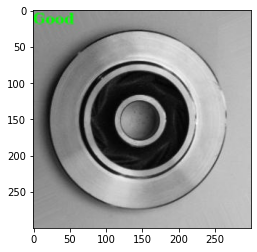

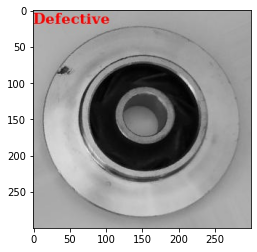

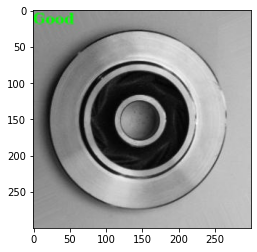

In [13]:
# displays the final processed images
for _,file in enumerate(output_list):
   img = mpimg.imread(file)
   imgplot = plt.imshow(img)
   plt.show()